In [1]:
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Parameters
batch_size = 16
img_size = (224, 224)
data_dir = "C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_cassava"

In [4]:
# Load dataset (tanpa split dulu)
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=None,
    shuffle=True
)

Found 21397 files belonging to 5 classes.


In [ ]:
# Convert to list
full_dataset = list(full_dataset)
images = [x[0].numpy() for x in full_dataset]
labels = [x[1].numpy() for x in full_dataset]

In [ ]:
# Split ke train/val/test: 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Convert ke  tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Normalisasi
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# Dapatkan jumlah kelas
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

In [29]:
# ==== HITUNG CLASS WEIGHTS ====
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights))

In [ ]:
# ==== BASE MODEL ====
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False

# ==== BUILD MODEL ====
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# ==== COMPILE ====
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
# ==== CALLBACKS ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [33]:
# ==== TRAIN ====
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
402/402 [==============================] - 907s 2s/step - loss: 1.1799 - accuracy: 0.5654 - val_loss: 1.1245 - val_accuracy: 0.5229 - lr: 0.0010
Epoch 2/20
402/402 [==============================] - 876s 2s/step - loss: 1.1286 - accuracy: 0.5924 - val_loss: 0.9834 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 3/20
402/402 [==============================] - 680s 2s/step - loss: 1.0826 - accuracy: 0.5976 - val_loss: 1.0144 - val_accuracy: 0.6058 - lr: 0.0010
Epoch 4/20
402/402 [==============================] - 705s 2s/step - loss: 1.0537 - accuracy: 0.6084 - val_loss: 0.9643 - val_accuracy: 0.6407 - lr: 0.0010
Epoch 5/20
402/402 [==============================] - 727s 2s/step - loss: 1.0257 - accuracy: 0.6158 - val_loss: 0.9512 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 6/20
402/402 [==============================] - 755s 2s/step - loss: 0.9909 - accuracy: 0.6288 - val_loss: 0.9719 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 7/20
402/402 [==============================] - 757s 2s/st

In [37]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [38]:
# Compile ulang dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
# Lanjutkan training
history_finetune = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds
)

Epoch 1/30
402/402 [==============================] - 1124s 3s/step - loss: 1.1976 - accuracy: 0.5618 - val_loss: 1.1055 - val_accuracy: 0.6175
Epoch 2/30
402/402 [==============================] - 1062s 3s/step - loss: 0.9622 - accuracy: 0.6484 - val_loss: 1.0550 - val_accuracy: 0.6369
Epoch 3/30
402/402 [==============================] - 1003s 2s/step - loss: 0.8629 - accuracy: 0.6791 - val_loss: 0.9625 - val_accuracy: 0.6713
Epoch 4/30
402/402 [==============================] - 987s 2s/step - loss: 0.7872 - accuracy: 0.7066 - val_loss: 0.9032 - val_accuracy: 0.7000
Epoch 5/30
402/402 [==============================] - 973s 2s/step - loss: 0.7255 - accuracy: 0.7287 - val_loss: 0.8312 - val_accuracy: 0.7262
Epoch 6/30
402/402 [==============================] - 991s 2s/step - loss: 0.6627 - accuracy: 0.7548 - val_loss: 0.7839 - val_accuracy: 0.7411
Epoch 7/30
402/402 [==============================] - 992s 2s/step - loss: 0.6088 - accuracy: 0.7772 - val_loss: 0.7652 - val_accuracy: 0.7

KeyboardInterrupt: 

In [23]:
# Evaluasi
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")

134/134 [==============================] - 163s 1s/step - loss: 0.7123 - accuracy: 0.7514
Test Accuracy: 75.14%


In [24]:
# ==== SIMPAN MODEL ====
model.save('C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/models/predict_model_disease_cassava.h5')


In [25]:
# Ambil label sebenarnya
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Lakukan prediksi
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

134/134 [==============================] - 159s 1s/step


                                precision    recall  f1-score   support

    Cassava___bacterial_blight       0.50      0.41      0.45       217
Cassava___brown_streak_disease       0.60      0.54      0.57       438
        Cassava___green_mottle       0.64      0.39      0.49       477
             Cassava___healthy       0.50      0.63      0.56       516
      Cassava___mosaic_disease       0.86      0.90      0.88      2632

                      accuracy                           0.75      4280
                     macro avg       0.62      0.57      0.59      4280
                  weighted avg       0.75      0.75      0.74      4280



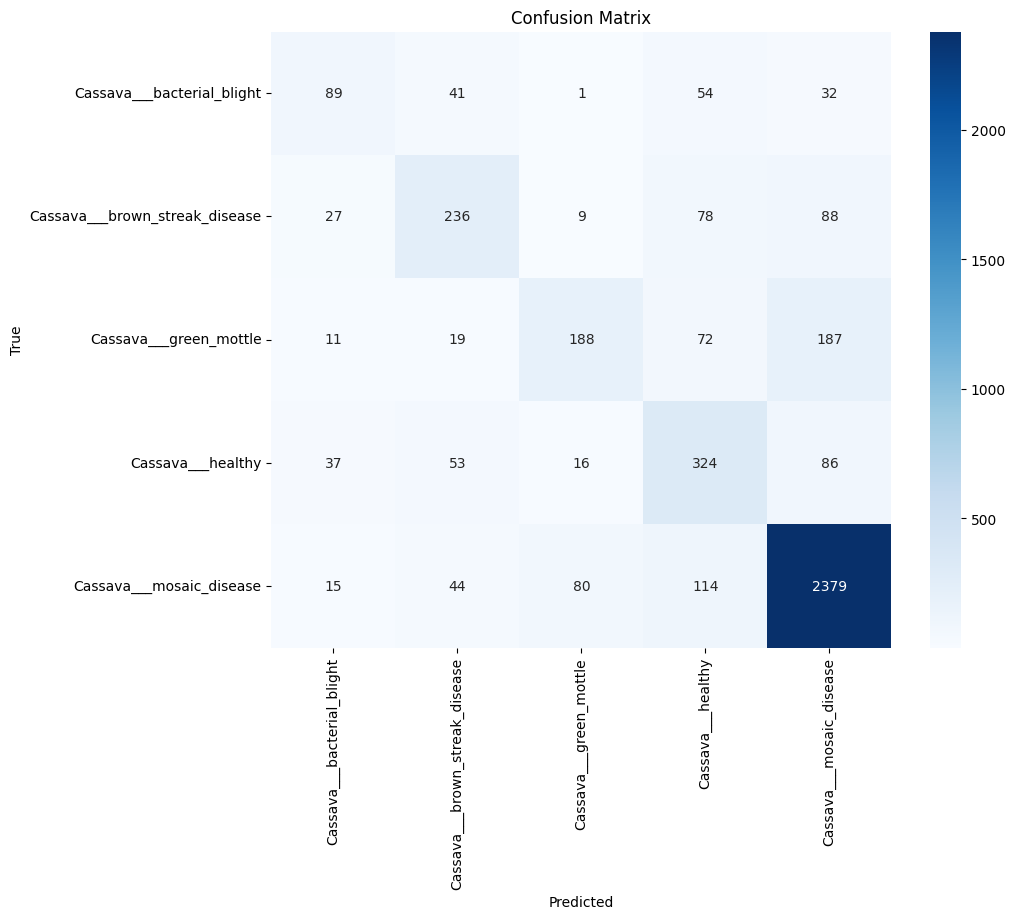

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Convert .h5 ke tflite_model
import tensorflow as tf

# Ganti dengan path model kamu
model = tf.keras.models.load_model('C:/Users/Sinta/Documents/Larskar AI/Capstone/AgroVA-app/models/predict_model_disease_wheat.h5')

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('C:/Users/Sinta/Documents/Larskar AI/Capstone/AgroVA-app/models/predict_model_disease_wheat.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Sinta\AppData\Local\Temp\tmppuxmwvat\assets


INFO:tensorflow:Assets written to: C:\Users\Sinta\AppData\Local\Temp\tmppuxmwvat\assets
